In [12]:
import os
os.chdir("C:/Users/cquir/OneDrive/Escritorio/dengineer/proyecto_reddit")

In [8]:
import pandas as pd
import reddit.src.utils.utils as utils
import re
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VaderSentimentAnalyzer
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine, text

from dotenv import load_dotenv

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cquir\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
#FUNCIONES DE UTILIDAD

def verificar_tipo_dato(dataframe):
        diccionario = {'nombre_campo': [], 'tipo_datos': [], 'no_nulos_%': [], 'nulos_%': [], 'nulos': []}
        for columna in dataframe.columns:
            porcentaje_no_nulos = (dataframe[columna].count()/len(dataframe[columna]))*100
            diccionario['nombre_campo'].append(columna)
            diccionario['tipo_datos'].append(dataframe[columna].apply(type).unique())
            diccionario['no_nulos_%'].append(round(porcentaje_no_nulos,2))
            diccionario['nulos_%'].append(round(100-porcentaje_no_nulos,2))
            diccionario['nulos'].append(dataframe[columna].isnull().sum())

        df = pd.DataFrame(diccionario)

        return df


def limpiar_texto_regex(texto):
        # reemplaza una expresion regular por un nuevo string.
        texto = re.sub(r'https?://\S+|www\.\S+', '', texto)     #Elimina enlaces URLs
        texto = re.sub(r'@\w+', '', texto)     #elimina menciones de usuario
        texto = re.sub(r'#\w+', '', texto)     #elimina hashtags
        texto = re.sub(r'[^\w\s,]', '', texto)     #elimina emojis
        texto = re.sub(r'([?!.,])\1+', '', texto)     #elimina caracteres de puntuacion excesivos o repeticiones, como !!!!!!!
        texto = re.sub(r'\s+', ' ', texto).strip()  # elimina espacios extra

        return texto

## Limpieza de datos

In [40]:
df = pd.read_csv("reddit/data/raw/all_comments.csv")
df

,id,parent_id,body,score,created_utc,author,depth,is_root
0,lvq1vli,t3_1gl0ty4,"\nAs a reminder, this subreddit [is for civil ...",1,2024-11-06 12:16:45,AutoModerator,0,True
1,lvqb0pp,t3_1gl0ty4,"When the ACA is killed, folks are going to bec...",9038,2024-11-06 12:57:36,mattaccino,0,True
2,lvqb5hs,t3_1gl0ty4,Everyone that voted for Trump will blame all w...,3083,2024-11-06 12:58:10,yukonhoneybadger,0,True
3,lvq49qg,t3_1gl0ty4,“Why do things cost more now? He said tariffs ...,12618,2024-11-06 12:27:32,2HDFloppyDisk,0,True
4,lvq20bn,t3_1gl0ty4,Just wait till the tariffs kick in,12792,2024-11-06 12:17:20,JWBeyond1,0,True
...,...,...,...,...,...,...,...,...
14775,lvq9010,t1_lvq5vjy,"With all 3 governing bodies, the ability to in...",334,2024-11-06 12:48:44,Lucavii,3,False
14776,lvqa58p,t1_lvq5vjy,That’s exactly what I’ve been saying. I don’t ...,71,2024-11-06 12:53:47,Nikkian42,3,False
14777,lvq9q6z,t1_lvq5vjy,That was just an Echelon,5,2024-11-06 12:51:58,clueless_as_fuck,3,False
14778,lvqthtc,t1_lvq5vjy,It's just a layer cake of Reagan/GWB/Trump bul...,2,2024-11-06 14:19:21,huskersax,3,False


In [41]:
#eliminamos el primer registro que es un comentario automatico del moderador
df.drop(0, inplace=True)

#verificamos los tipos de datos y nulos
verificar_tipo_dato(df)

,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,id,[<class 'str'>],100.00,0.00,0
1,parent_id,[<class 'str'>],100.00,0.00,0
2,body,"[<class 'str'>, <class 'float'>]",99.99,0.01,1
3,score,[<class 'int'>],100.00,0.00,0
4,created_utc,[<class 'str'>],100.00,0.00,0
5,author,[<class 'str'>],100.00,0.00,0
6,depth,[<class 'int'>],100.00,0.00,0
7,is_root,[<class 'bool'>],100.00,0.00,0


In [42]:
#busco el registro float para eliminarlo
df[df['body'].apply(lambda x: isinstance(x, float))]

,id,parent_id,body,score,created_utc,author,depth,is_root
12040,lvrcd5t,t1_lvrb33x,NaN,1,2024-11-06 15:44:37,VillageIdiotNo1,1,False


In [43]:
#elimino el registro anterior
df.drop(12040, inplace=True)  

In [44]:
#aplicamos funcion limpiar_texto_regex de expresiones innecesarias
df['format_comment'] = df['body'].apply(limpiar_texto_regex)

#elimino columna body
df.drop('body', axis=1, inplace=True)
df

,id,parent_id,score,created_utc,author,depth,is_root,format_comment
1,lvqb0pp,t3_1gl0ty4,9038,2024-11-06 12:57:36,mattaccino,0,True,"When the ACA is killed, folks are going to bec..."
2,lvqb5hs,t3_1gl0ty4,3083,2024-11-06 12:58:10,yukonhoneybadger,0,True,Everyone that voted for Trump will blame all w...
3,lvq49qg,t3_1gl0ty4,12618,2024-11-06 12:27:32,2HDFloppyDisk,0,True,Why do things cost more now He said tariffs wo...
4,lvq20bn,t3_1gl0ty4,12792,2024-11-06 12:17:20,JWBeyond1,0,True,Just wait till the tariffs kick in
5,lvq4wwk,t3_1gl0ty4,2984,2024-11-06 12:30:26,[deleted],0,True,"Its gonna bite them in the ass, sooner than th..."
...,...,...,...,...,...,...,...,...
14775,lvq9010,t1_lvq5vjy,334,2024-11-06 12:48:44,Lucavii,3,False,"With all 3 governing bodies, the ability to in..."
14776,lvqa58p,t1_lvq5vjy,71,2024-11-06 12:53:47,Nikkian42,3,False,Thats exactly what Ive been saying I dont thin...
14777,lvq9q6z,t1_lvq5vjy,5,2024-11-06 12:51:58,clueless_as_fuck,3,False,That was just an Echelon
14778,lvqthtc,t1_lvq5vjy,2,2024-11-06 14:19:21,huskersax,3,False,Its just a layer cake of ReaganGWBTrump bullsh...


## Análisis de sentimiento

#### En base a 3 librerías que procesan datos de texto (textblob, nltk y vader), se analizará la polaridad de los comentarios hechos por los usuarios de reddit con el objetivo de observar que tan polarizados se encuentran respecto a la victoria de Donald Trump en las elecciones de 2024 en Estados Unidos.

In [49]:
#compara resultados de diferentes analizadores de sentimiento
def comparador_analizadores_sentimiento(textos):
    results = []
    sia = SentimentIntensityAnalyzer()
    vader = VaderSentimentAnalyzer()

    for texto in textos:
        try:
            #para textblob
            blob = TextBlob(texto)
            textblob_score = blob.sentiment.polarity  
            
            #para nltk
            nltk_score = sia.polarity_scores(texto)
            nltk_compound = nltk_score['compound']

            #para vader
            vader_score = vader.polarity_scores(texto)
            vader_compound = vader_score['compound']

            results.append({
                'texto': texto,
                'textblob_score': textblob_score,
                'nltk_score': nltk_compound,
                'vader_score': vader_compound,
                'textblob_sentiment': 'positivo' if textblob_score > 0 else 'negativo' if textblob_score < 0 else 'neutral',
                'nltk_sentiment': 'positivo' if nltk_compound >= 0.05 else 'negativo' if nltk_compound <= -0.05 else 'neutral',
                'vader_sentiment': 'positivo' if vader_compound >= 0.05 else 'negativo' if vader_compound <= -0.05 else 'neutral'
            })
        
        except Exception as e:
            print(f"Error procesando texto: {texto[:50]}... Error: {str(e)}")
            continue

    return pd.DataFrame(results)

In [50]:
df_polaridad = comparador_analizadores_sentimiento(df['format_comment'])
df_polaridad

,texto,textblob_score,nltk_score,vader_score,textblob_sentiment,nltk_sentiment,vader_sentiment
0,"When the ACA is killed, folks are going to bec...",-0.333333,-0.8481,-0.8481,negativo,negativo,negativo
1,Everyone that voted for Trump will blame all w...,-0.377778,-0.8126,-0.8126,negativo,negativo,negativo
2,Why do things cost more now He said tariffs wo...,0.500000,0.0000,0.0000,positivo,neutral,neutral
3,Just wait till the tariffs kick in,0.000000,0.0000,0.0000,neutral,neutral,neutral
4,"Its gonna bite them in the ass, sooner than th...",-0.075000,-0.7906,-0.7906,negativo,negativo,negativo
...,...,...,...,...,...,...,...
14773,"With all 3 governing bodies, the ability to in...",0.338333,0.9259,0.9259,positivo,positivo,positivo
14774,Thats exactly what Ive been saying I dont thin...,0.128788,-0.4939,-0.4939,positivo,negativo,negativo
14775,That was just an Echelon,0.000000,0.0000,0.0000,neutral,neutral,neutral
14776,Its just a layer cake of ReaganGWBTrump bullsh...,0.000000,-0.5859,-0.5859,neutral,negativo,negativo


In [ ]:
def ponderacion_sentimiento(dataframe):
    
    for index, row in dataframe.iterrows():
        #creo una lista que se renueva en cada iteración que pondera los 3 analizadores
        sentiment = [row['textblob_sentiment'], row['nltk_sentiment'], row['vader_sentiment']]
        if sentiment.count('positivo') >= 2:
            dataframe.at[index, 'sentimiento_final'] = 'positivo'
        elif sentiment.count('negativo') >= 2:
            dataframe.at[index, 'sentimiento_final'] = 'negativo'
        else:
            dataframe.at[index, 'sentimiento_final'] = 'neutral'

    return dataframe

In [54]:
df_final = ponderacion_sentimiento(df_polaridad)
df_final

,texto,textblob_score,nltk_score,vader_score,textblob_sentiment,nltk_sentiment,vader_sentiment,sentimiento_final
0,"When the ACA is killed, folks are going to bec...",-0.333333,-0.8481,-0.8481,negativo,negativo,negativo,negativo
1,Everyone that voted for Trump will blame all w...,-0.377778,-0.8126,-0.8126,negativo,negativo,negativo,negativo
2,Why do things cost more now He said tariffs wo...,0.500000,0.0000,0.0000,positivo,neutral,neutral,neutral
3,Just wait till the tariffs kick in,0.000000,0.0000,0.0000,neutral,neutral,neutral,neutral
4,"Its gonna bite them in the ass, sooner than th...",-0.075000,-0.7906,-0.7906,negativo,negativo,negativo,negativo
...,...,...,...,...,...,...,...,...
14773,"With all 3 governing bodies, the ability to in...",0.338333,0.9259,0.9259,positivo,positivo,positivo,positivo
14774,Thats exactly what Ive been saying I dont thin...,0.128788,-0.4939,-0.4939,positivo,negativo,negativo,negativo
14775,That was just an Echelon,0.000000,0.0000,0.0000,neutral,neutral,neutral,neutral
14776,Its just a layer cake of ReaganGWBTrump bullsh...,0.000000,-0.5859,-0.5859,neutral,negativo,negativo,negativo


In [55]:
df_final['sentimiento_final'].value_counts()

sentimiento_final
negativo    6279
positivo    5394
neutral     3105
Name: count, dtype: int64

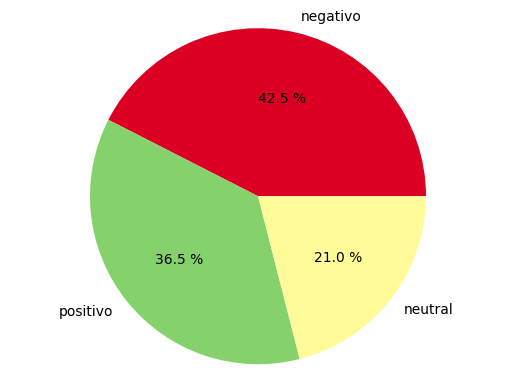

In [67]:
#grafico con matplotlib
labels = 'negativo', 'positivo', 'neutral'
colors = ['#db0023', '#85d26c', '#fffb99']
plt.pie(df_final['sentimiento_final'].value_counts(), labels = labels, colors = colors, autopct="%0.1f %%")
plt.axis('equal')
plt.show()